In [1]:
import sys
sys.path.append('..')

from helper_fun import *
import helper_fun
from Split_functions_classify.splits_two import *
from Split_functions_classify.splits_three import *
from Split_functions_classify.splits_ten import *

SEED = 22
seed_everything(SEED)

compounds = pd.read_csv('../COVID_MOONSHOT/compounds_filtered.csv')
compounds.head(2)

/home/alex/miniforge3/envs/my-rdkit-env-covid/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-07 10:24:41.514811: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 10:24:41.769295: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Unnamed: 0                              SMILES                  CID  \
0          35  N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1  DAR-DIA-23aa0b97-19   
1          36       O=C(Cc1cncc2ccccc12)Nc1ccccc1  DAR-DIA-23aa0b97-20   

   f_avg_IC50  r_avg_IC50                                             ROMol  \
0   26.719515   14.641091  <rdkit.Chem.rdchem.Mol object at 0x7fc319ac34c0>   
1   57.590417   45.077469  <rdkit.Chem.rdchem.Mol object at 0x7fc319ac3530>   

   molecular_weight  n_hba  n_hbd     logp  Ro5_fulfilled  f_avg_pIC50  \
0        287.105862      3      1  3.28768           True     4.573171   
1        262.110613      2      1  3.41600           True     4.239650   

   r_avg_pIC50  
0     4.834427  
1     4.346040

In [2]:
two_split(compounds)
three_split(compounds)
ten_split(compounds).head()
compound_df = compounds.copy()
compound_df["maccs"] = compound_df["SMILES"].apply(smiles_to_fp,)

In [3]:
#change variables to _2 at end
fingerprint_to_model = compound_df.maccs.tolist()
label_to_model_2 = compound_df.bin_2.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x_2,
    static_test_x_2,
    static_train_y_2,
    static_test_y_2,
) = train_test_split(fingerprint_to_model, label_to_model_2, test_size=0.2, random_state=SEED)
splits_2 = [static_train_x_2, static_test_x_2, static_train_y_2, static_test_y_2]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x_2))
print("Test data size:", len(static_test_x_2))


Training data size: 476
Test data size: 119


In [4]:
# Specify models for 3 bin types
model_SVM_2 = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)
model_SVM_3 = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)
model_SVM_10 = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

In [5]:
model_evaluation = {}

## 2 Bin ##

In [6]:
performance_measures = model_training_and_validation(model_SVM_2, "SVM", splits_2)

Sensitivity: 0.75
Specificity: 0.73
AUC: 0.82


In [7]:
bins_label_2 = ["0","1"]

### ROC curve ###

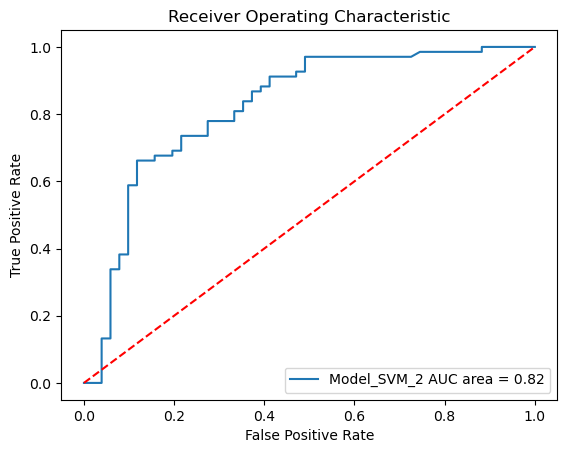

In [8]:
# Create a list for our models
models = [{"label": "Model_SVM_2", "model": model_SVM_2}]
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x_2, static_test_y_2, False);

In [9]:
# Get the predicted probabilities for the positive class
y_pred_proba_2 = model_SVM_2.predict_proba(static_test_x_2)[:, 1]
# Calculate the AUC area
auc_SVM_2 = roc_auc_score(static_test_y_2, y_pred_proba_2)

### MCC - helps us determine quality of binary classifications ### 

MCC takes a value between -1 and 1

In [10]:
y_pred_SVM_2 = model_SVM_2.predict(static_test_x_2)
matthews_corrcoef_SVM_2 = matthews_corrcoef(static_test_y_2,y_pred_SVM_2)
print("The matthews correlation coefficient is:",matthews_corrcoef_SVM_2)

The matthews correlation coefficient is: 0.47263682151545466


### F1 score ###

F1 score takes a value between 0 and 1

In [11]:
f1_score_SVM_2 = f1_score(static_test_y_2,y_pred_SVM_2)
print("F1 score is:",f1_score_SVM_2)

F1 score is: 0.7669172932330827


In [12]:
model_evaluation["model_SVM_2"] = {"AUC": auc_SVM_2, "MCC": matthews_corrcoef_SVM_2, "F1": f1_score_SVM_2}

## Look at parameter hyper-parameter tuning ##

In [13]:
print(model_SVM_2.get_params())
print(classification_report(static_test_y_2, y_pred_SVM_2))
print(model_SVM_2.score(static_test_x_2, static_test_y_2))

{'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
              precision    recall  f1-score   support

           0       0.69      0.73      0.70        51
           1       0.78      0.75      0.77        68

    accuracy                           0.74       119
   macro avg       0.73      0.74      0.74       119
weighted avg       0.74      0.74      0.74       119

0.7394957983193278


In [14]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1,5,6,7,8,9,10],
    'gamma': [0.01, 0.1, 1,10,100],
    'kernel': ['linear', 'rbf','poly','sigmoid'],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model_SVM_2, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(static_train_x_2, static_train_y_2)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

KeyboardInterrupt: 

In [ ]:
model_SVM_2.set_params(**best_params)
model_SVM_2.fit(static_train_x_2, static_train_y_2)

SVC(C=9, gamma=0.1, probability=True)

In [ ]:
y_pred_SVM_2_GS = model_SVM_2.predict(static_test_x_2)

In [ ]:
print(model_SVM_2.get_params())
print(classification_report(static_test_y_2, y_pred_SVM_2_GS))
print(model_SVM_2.score(static_test_x_2, static_test_y_2))

{'C': 9, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
              precision    recall  f1-score   support

           0       0.74      0.76      0.75        51
           1       0.82      0.79      0.81        68

    accuracy                           0.78       119
   macro avg       0.78      0.78      0.78       119
weighted avg       0.78      0.78      0.78       119

0.7815126050420168


### Replot the ROC curve with updated parameters as well as MCC and F1 ###

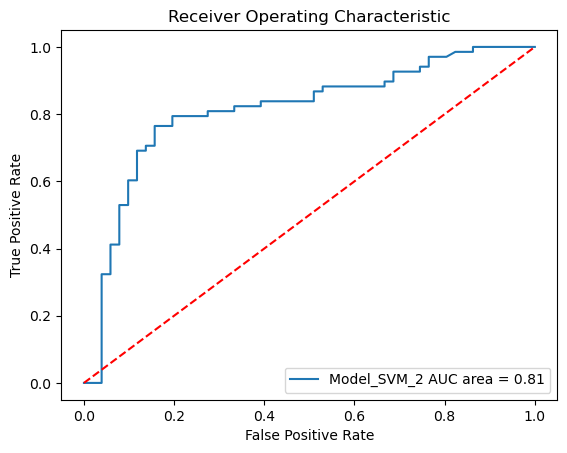

In [ ]:
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x_2, static_test_y_2, False);

In [ ]:
# Get the predicted probabilities for the positive class
y_pred_proba_2_GS = model_SVM_2.predict_proba(static_test_x_2)[:, 1]
# Calculate the AUC area
auc_SVM_2_GS = roc_auc_score(static_test_y_2, y_pred_proba_2_GS)

In [ ]:
matthews_corrcoef_SVM_2_GS = matthews_corrcoef(static_test_y_2,y_pred_SVM_2_GS)
print("The matthews correlation coefficient is:",matthews_corrcoef_SVM_2_GS)

The matthews correlation coefficient is: 0.5564220420245516


In [ ]:
f1_score_SVM_2_GS = f1_score(static_test_y_2,y_pred_SVM_2_GS)
print("F1 score is:",f1_score_SVM_2_GS)

F1 score is: 0.8059701492537313


In [ ]:
model_evaluation["model_SVM_2_GS"] = {"AUC": auc_SVM_2_GS, "MCC": matthews_corrcoef_SVM_2_GS, "F1": f1_score_SVM_2_GS}

## Optuna for hyperparameter tuning ##

In [ ]:
from optuna.samplers import TPESampler

In [ ]:
def objective(trial):
    C = trial.suggest_loguniform("C", 1e-10, 1e2)
    gamma = trial.suggest_loguniform("gamma", 1e-10, 1e1)
    kernel = trial.suggest_categorical("kernel", ['linear', 'rbf','poly','sigmoid'])

    model = svm.SVC(C=C, gamma=gamma, kernel=kernel, probability=True)
    model.fit(static_train_x_2, static_train_y_2)
    y_pred = model.predict(static_test_x_2)
    y_pred_proba = model.predict_proba(static_test_x_2)[:, 1]
    return f1_score(static_test_y_2, y_pred), roc_auc_score(static_test_y_2, y_pred_proba), matthews_corrcoef(static_test_y_2,y_pred)

In [ ]:
study = optuna.create_study(directions=["maximize","maximize","maximize"],sampler=TPESampler(seed=SEED))
study.optimize(objective, n_trials=100000, timeout=360, n_jobs=8)

[I 2024-08-05 14:24:53,140] A new study created in memory with name: no-name-f43698a1-20c8-47d1-8e3d-f65558ea05ad
/tmp/ipykernel_623846/681171665.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-10, 1e2)
/tmp/ipykernel_623846/681171665.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform("gamma", 1e-10, 1e1)
/tmp/ipykernel_623846/681171665.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-10, 1e2)
/tmp/

KeyboardInterrupt: 

In [ ]:
optuna.visualization.plot_pareto_front(study, target_names=["F1", "AUC","MCC"])

In [ ]:
best_trials = study.best_trials

In [ ]:
values = [trial.values for trial in best_trials]
print(values)
sum_of_squares = [sum([x**2 for x in trial]) for trial in values]
max_index = sum_of_squares.index(max(sum_of_squares))
print(values[max_index])
best_param_SVM_2 = best_trials[max_index].params

NameError: name 'best_trials' is not defined

In [ ]:
model_SVM_2.set_params(**best_param_SVM_2)
model_SVM_2.fit(static_train_x_2, static_train_y_2)

SVC(C=0.9082928437011518, gamma=0.24282494562687262, probability=True)

### Replot the ROC curve with updated parameters from optuna as well as MCC and F1 ###

In [ ]:
y_pred_SVM_2_Optuna = model_SVM_2.predict(static_test_x_2)

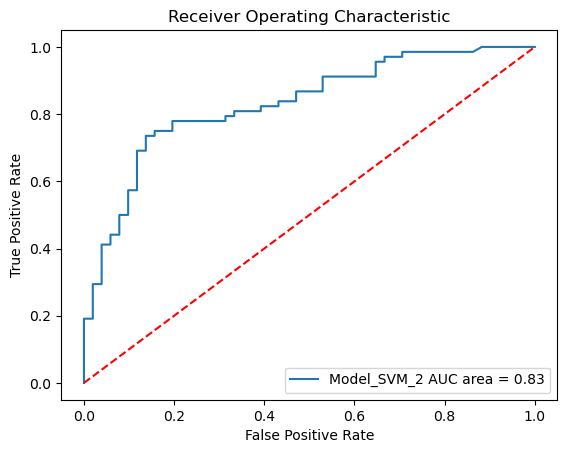

In [ ]:
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x_2, static_test_y_2, False);

In [ ]:
# Get the predicted probabilities for the positive class
y_pred_proba_2_Optuna = model_SVM_2.predict_proba(static_test_x_2)[:, 1]
# Calculate the AUC area
auc_SVM_2_Optuna = roc_auc_score(static_test_y_2, y_pred_proba_2_Optuna)

In [ ]:
matthews_corrcoef_SVM_2_Optuna = matthews_corrcoef(static_test_y_2,y_pred_SVM_2_Optuna)
print("The matthews correlation coefficient is:",matthews_corrcoef_SVM_2_Optuna)

The matthews correlation coefficient is: 0.5924284891938661


In [ ]:
f1_score_SVM_2_Optuna = f1_score(static_test_y_2,y_pred_SVM_2_Optuna)
print("F1 score is:",f1_score_SVM_2_Optuna)

F1 score is: 0.8


In [ ]:
model_evaluation["model_SVM_2_Optuna"] = {"AUC": auc_SVM_2_Optuna, "MCC": matthews_corrcoef_SVM_2_Optuna, "F1": f1_score_SVM_2_Optuna}

In [ ]:
pd.DataFrame(model_evaluation).T

AUC       MCC        F1
model_SVM_2         0.822232  0.472637  0.766917
model_SVM_2_GS      0.812716  0.556422  0.805970
model_SVM_2_Optuna  0.831459  0.592428  0.800000

We see a slight performance boost in our model

# Test on furthest cluster #

We now look to test our data on the furthest cluster of compounds when we plot on umap. This will allow us to gain insight into whether our model generalizes.

In [ ]:
from Split_functions_regression.split_furthest_cluster import *

We define our model using the parameters we got from Optuna

In [ ]:
model_SVM_2.set_params(**best_param_SVM_2)

SVC(C=0.9082928437011518, gamma=0.24282494562687262, probability=True)

We will also save this model as it is the best we have so far using our random split so will be helper to be able to call on it again

In [ ]:
import joblib

In [ ]:
joblib_file = "best_model_SVM_2.pkl"
joblib.dump(model_SVM_2, joblib_file)

['best_model_SVM_2.pkl']

In [ ]:
joblib.load("Optuna_model_SVM_2.pkl")

SVC(C=3.9942666781667944, gamma=0.24545637263753847, probability=True)

Create our furthest cluster splits

In [ ]:
X_test_2_furth, X_train_2_furth, Y_test_2_furth, Y_train_2_furth = furthest_cluster_split(compounds, smiles_column="SMILES", CID_column="CID", pIC50_column="bin_2")

  0%|          | 0/595 [00:00<?, ?it/s][10:50:27] DEPRECATION WARNING: please use MorganGenerator
[10:50:27] DEPRECATION WARNING: please use MorganGenerator
[10:50:27] DEPRECATION WARNING: please use MorganGenerator
[10:50:27] DEPRECATION WARNING: please use MorganGenerator
[10:50:27] DEPRECATION WARNING: please use MorganGenerator
[10:50:27] DEPRECATION WARNING: please use MorganGenerator
[10:50:27] DEPRECATION WARNING: please use MorganGenerator
[10:50:27] DEPRECATION WARNING: please use MorganGenerator
[10:50:27] DEPRECATION WARNING: please use MorganGenerator
[10:50:27] DEPRECATION WARNING: please use MorganGenerator
[10:50:27] DEPRECATION WARNING: please use MorganGenerator
[10:50:27] DEPRECATION WARNING: please use MorganGenerator
[10:50:27] DEPRECATION WARNING: please use MorganGenerator
[10:50:27] DEPRECATION WARNING: please use MorganGenerator
[10:50:27] DEPRECATION WARNING: please use MorganGenerator
[10:50:27] DEPRECATION WARNING: please use MorganGenerator
[10:50:27] DEPREC

Now train our model on the most similar compounds

In [ ]:
X_train_2_furth = X_train_2_furth.to_list()
Y_train_2_furth = Y_train_2_furth.to_list()
X_test_2_furth = X_test_2_furth.to_list()
Y_test_2_furth = Y_test_2_furth.to_list()

In [ ]:
model_SVM_2.fit(X_train_2_furth, Y_train_2_furth)

SVC(C=0.9082928437011518, gamma=0.24282494562687262, probability=True)

### Plot ROC and coefficients ###

In [ ]:
y_pred_SVM_2_furth = model_SVM_2.predict(X_test_2_furth)

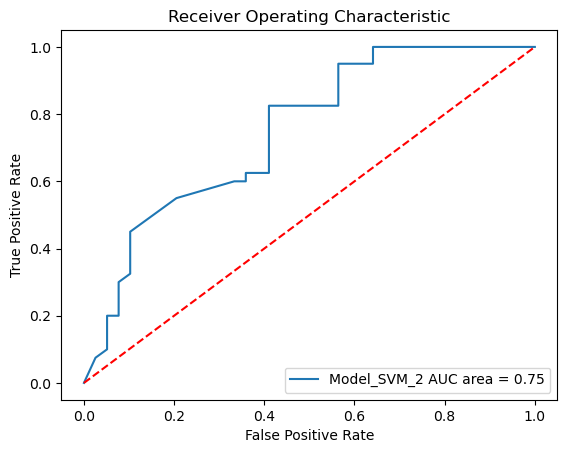

In [ ]:
plot_roc_curves_for_models(models, X_test_2_furth, Y_test_2_furth, False);

So we can see the model is now not as strong, but not awful the curve is still in the upper left and the AUC is okay

In [ ]:
# Get the predicted probabilities for the positive class
y_pred_proba_2_furth = model_SVM_2.predict_proba(X_test_2_furth)[:, 1]
# Calculate the AUC area
auc_SVM_2_furth = roc_auc_score(Y_test_2_furth, y_pred_proba_2_furth)

In [ ]:
matthews_corrcoef_SVM_2_furth = matthews_corrcoef(Y_test_2_furth,y_pred_SVM_2_furth)
print("The matthews correlation coefficient is:",matthews_corrcoef_SVM_2_furth)

The matthews correlation coefficient is: 0.3467613389126285


In [ ]:
f1_score_SVM_2_furth = f1_score(Y_test_2_furth,y_pred_SVM_2_furth)
print("F1 score is:",f1_score_SVM_2_Optuna)

F1 score is: 0.8


In [ ]:
model_evaluation["model_SVM_2_Furthest_cluster"] = {"AUC": auc_SVM_2_furth, "MCC": matthews_corrcoef_SVM_2_furth, "F1": f1_score_SVM_2_furth}

# 3 bin #

Make our training and test data for the 3 split

In [16]:
label_to_model_3 = compound_df.bin_3.to_list()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x_3,
    static_test_x_3,
    static_train_y_3,
    static_test_y_3,
) = train_test_split(fingerprint_to_model, label_to_model_3, test_size=0.2, random_state=SEED)
splits_3 = [static_train_x_3, static_test_x_3, static_train_y_3, static_test_y_3]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x_3))
print("Test data size:", len(static_test_x_3))

Training data size: 476
Test data size: 119


In [17]:
bins_label_3 = ['low','medium','high']

In [18]:
model_SVM_3.fit(static_train_x_3,static_train_y_3)
test_prob_3 = model_SVM_3.predict_proba(static_test_x_3)

### Plot the ROC curves using One vs Rest and micro-averaging ###

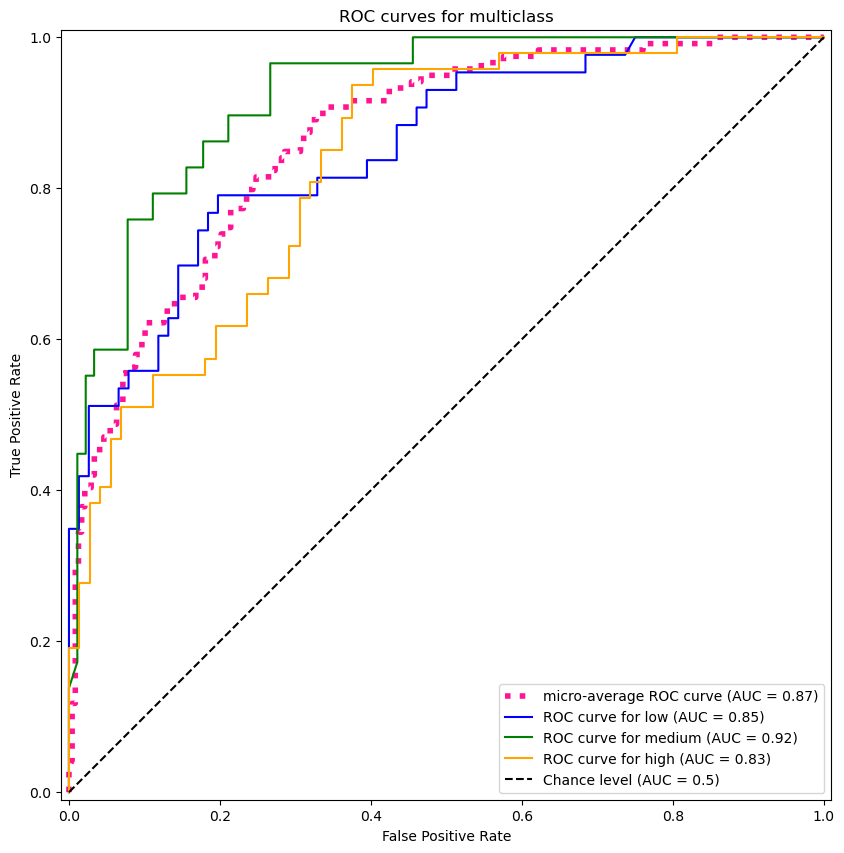

In [19]:
plot_roc_for_multi_class(model_SVM_3,static_test_x_3,static_train_y_3,static_test_y_3,bins_label_3,True,True)

In [ ]:
auc_SVM_3 = calculate_micro_auc(model_SVM_3,static_test_x_3,static_train_y_3,static_test_y_3)
print(auc_SVM_3)

0.866040533860603


### MCC for 3 classes ###

In [ ]:
y_pred_SVM_3 = model_SVM_3.predict(static_test_x_3)
matthews_corrcoef_SVM_3 = matthews_corrcoef(static_test_y_3,y_pred_SVM_3)
print("MCC:",matthews_corrcoef_SVM_3)

MCC: 0.6577546968917508


This shows bad performance when we drastically increase the number of bins

### F1 for multi-class (3 classes here) ###

Have to specify average as this is not a binary class

In [ ]:
f1_score_SVM_3_micro = f1_score(static_test_y_3,y_pred_SVM_3,average="micro")
print("F1 score using micro average is:",f1_score_SVM_3_micro)

F1 score using micro average is: 0.773109243697479


In [ ]:
f1_score_SVM_3_macro = f1_score(static_test_y_3,y_pred_SVM_3,average="macro")
print("F1 score using macro average is:",f1_score_SVM_3_macro)

F1 score using macro average is: 0.7748269336122316


In [ ]:
model_evaluation["model_SVM_3"] = {"AUC": auc_SVM_3, "MCC": matthews_corrcoef_SVM_3, "F1": f1_score_SVM_3_micro}

In [ ]:
model_evaluation

{'model_SVM_2': {'AUC': 0.8222318339100346,
  'MCC': 0.47263682151545466,
  'F1': 0.7669172932330827},
 'model_SVM_2_GS': {'AUC': 0.8127162629757786,
  'MCC': 0.5564220420245516,
  'F1': 0.8059701492537313},
 'model_SVM_2_Optuna': {'AUC': 0.8314590542099193,
  'MCC': 0.5924284891938661,
  'F1': 0.8},
 'model_SVM_2_Furthest_cluster': {'AUC': 0.7477564102564103,
  'MCC': 0.3467613389126285,
  'F1': 0.7216494845360825},
 'model_SVM_3': {'AUC': 0.9008897676717746,
  'MCC': 0.6577546968917508,
  'F1': 0.773109243697479}}

## Look at hyper-parameter tuning ##

In [ ]:
print(model_SVM_3.get_params())
print(classification_report(static_test_y_3, y_pred_SVM_3))
print(model_SVM_3.score(static_test_x_3, static_test_y_3))

{'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
              precision    recall  f1-score   support

        high       0.69      0.82      0.75        33
         low       0.85      0.78      0.81        36
      medium       0.79      0.74      0.76        50

    accuracy                           0.77       119
   macro avg       0.78      0.78      0.77       119
weighted avg       0.78      0.77      0.77       119

0.773109243697479


In [ ]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1,5,6,7,8,9,10],
    'gamma': [0.01,0.05, 0.1,1.5, 1,10,100],
    'kernel': ['linear', 'rbf','poly','sigmoid'],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model_SVM_3, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(static_train_x_3, static_train_y_3)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score: 0.7331578947368422


In [ ]:
model_SVM_3.set_params(**best_params)
model_SVM_3.fit(static_train_x_3, static_train_y_3)

SVC(C=10, gamma=0.1, probability=True)

### Plot ROC with updated parameters ###

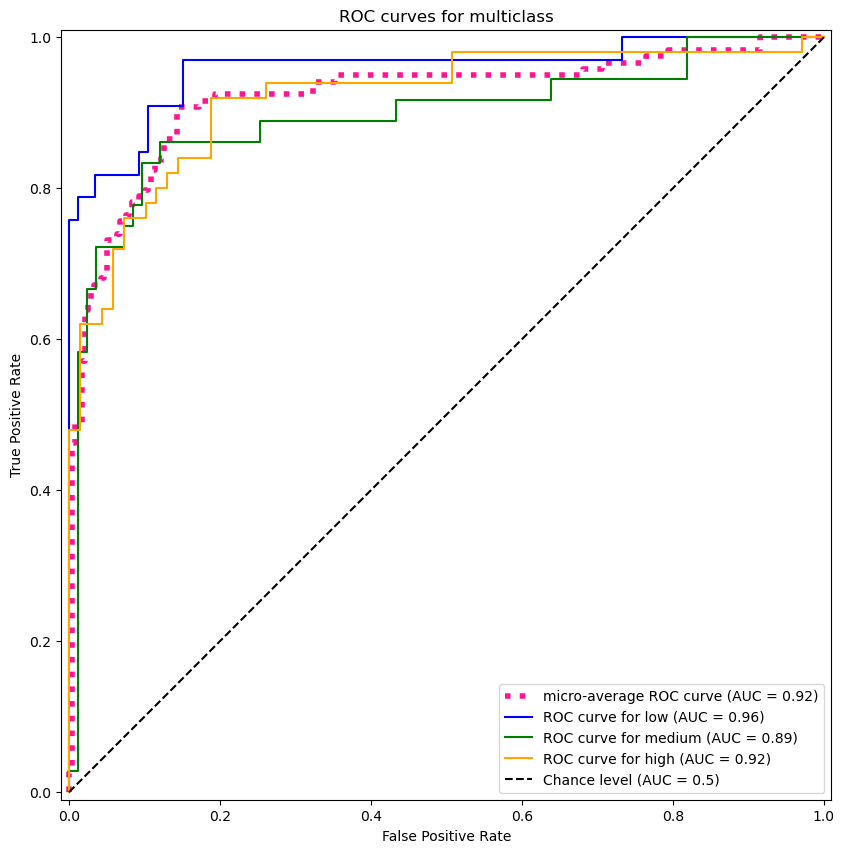

In [ ]:
plot_roc_for_multi_class(model_SVM_3,static_test_x_3,static_train_y_3,static_test_y_3,bins_label_3,True,True)

In [ ]:
auc_SVM_3_GS = calculate_micro_auc(model_SVM_3,static_test_x_3,static_train_y_3,static_test_y_3)
print(auc_SVM_3_GS)

0.9204858413953817


### MCC and F1 with updated parameters ###

In [ ]:
y_pred_SVM_3_GS = model_SVM_3.predict(static_test_x_3)


In [ ]:
matthews_corrcoef_SVM_3_GS = matthews_corrcoef(static_test_y_3,y_pred_SVM_3_GS)
print("MCC:",matthews_corrcoef_SVM_3_GS)

MCC: 0.7094057621183679


In [ ]:
f1_score_SVM_3_micro_GS = f1_score(static_test_y_3,y_pred_SVM_3_GS,average="micro")
print("F1 score using micro average is:",f1_score_SVM_3_micro_GS)

F1 score using micro average is: 0.8067226890756303


In [ ]:
f1_score_SVM_3_macro_GS = f1_score(static_test_y_3,y_pred_SVM_3_GS,average="macro")
print("F1 score using macro average is:",f1_score_SVM_3_macro_GS)

F1 score using macro average is: 0.8057539682539683


Can see a clear improvement in our coefficients here

In [ ]:
model_evaluation["model_SVM_3_GS"] = {"AUC": auc_SVM_3_GS, "MCC": matthews_corrcoef_SVM_3_GS, "F1": f1_score_SVM_3_micro_GS}

In [ ]:
pd.DataFrame(model_evaluation).T

AUC       MCC        F1
model_SVM_2                   0.822232  0.472637  0.766917
model_SVM_2_GS                0.812716  0.556422  0.805970
model_SVM_2_Optuna            0.831459  0.592428  0.800000
model_SVM_2_Furthest_cluster  0.747756  0.346761  0.721649
model_SVM_3                   0.900890  0.657755  0.773109
model_SVM_3_GS                0.920486  0.709406  0.806723

## Optuna ##

In [ ]:
def objective(trial):
    C = trial.suggest_loguniform("C", 1e-10, 1e2)
    gamma = trial.suggest_loguniform("gamma", 1e-10, 1e1)
    kernel = trial.suggest_categorical("kernel", ['linear', 'rbf','poly','sigmoid'])

    model = svm.SVC(C=C, gamma=gamma, kernel=kernel, probability=True)
    model.fit(static_train_x_3, static_train_y_3)
    y_pred = model.predict(static_test_x_3)
    return f1_score(static_test_y_3, y_pred,average="micro"), calculate_micro_auc(model,static_test_x_3,static_train_y_3,static_test_y_3), matthews_corrcoef(static_test_y_3,y_pred)


In [ ]:
study = optuna.create_study(directions=["maximize","maximize","maximize"],sampler=TPESampler(seed=SEED))
study.optimize(objective, n_trials=100000, timeout=360, n_jobs=8)

[I 2024-07-30 10:51:58,922] A new study created in memory with name: no-name-8f2325bd-ab99-4149-9c9d-8ebe6e2bb406


/tmp/ipykernel_443127/4272903727.py:2: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/tmp/ipykernel_443127/4272903727.py:3: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/tmp/ipykernel_443127/4272903727.py:2: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/tmp/ipykernel_443127/4272903727.py:3: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/tmp/ipykernel_4

In [ ]:
best_trials = study.best_trials
values = [trial.values for trial in best_trials]
print(values)
sum_of_squares = [sum([x**2 for x in trial]) for trial in values]
max_index = sum_of_squares.index(max(sum_of_squares))
print(values[max_index])
best_param_SVM_3 = best_trials[max_index].params
model_SVM_3.set_params(**best_param_SVM_3)
model_SVM_3.fit(static_train_x_3, static_train_y_3)

[[0.8151260504201681, 0.9072099428006497, 0.7235318256317251], [0.8067226890756303, 0.9384577360355908, 0.7107639142177372], [0.8067226890756303, 0.9373631805663443, 0.7186090748778318], [0.7899159663865546, 0.9391992090954029, 0.6955937140862897], [0.8151260504201681, 0.9192500529623615, 0.7209636984852122]]
[0.8067226890756303, 0.9373631805663443, 0.7186090748778318]


SVC(C=1.8219516103083035, gamma=0.4513673471073346, probability=True)

### ROC with parameter from Optuna ###

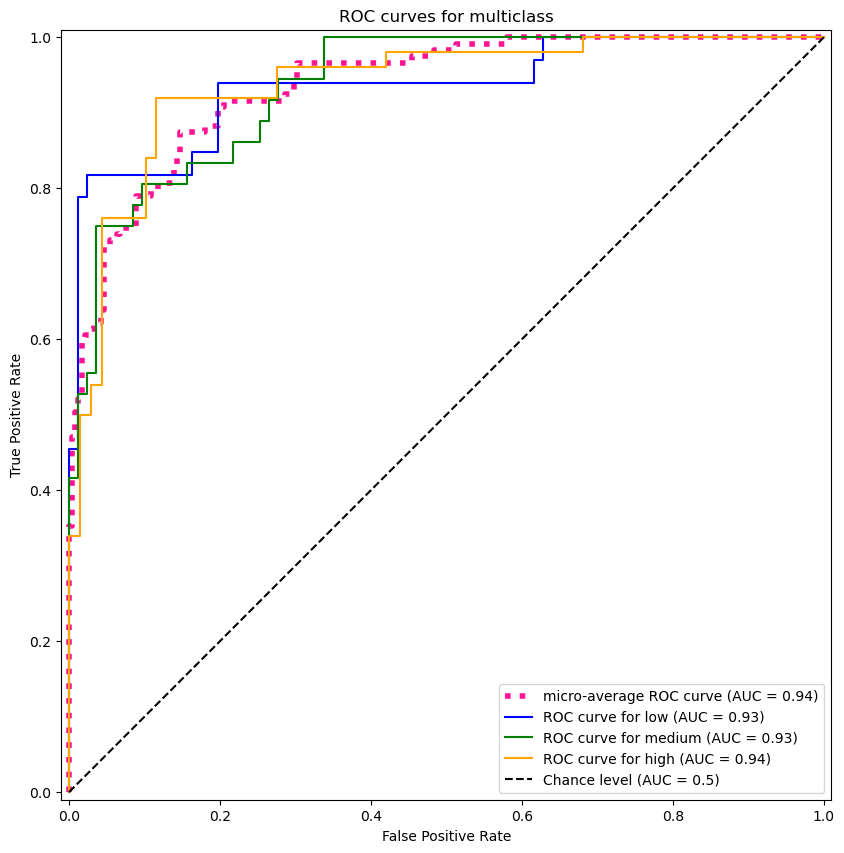

In [ ]:
plot_roc_for_multi_class(model_SVM_3,static_test_x_3,static_train_y_3,static_test_y_3,bins_label_3,True,True)

In [ ]:
auc_SVM_3_Optuna = calculate_micro_auc(model_SVM_3,static_test_x_3,static_train_y_3,static_test_y_3)
print(auc_SVM_3_Optuna)

0.9353153025916249


### MCC and F1 with updated parameters ###

In [ ]:
y_pred_SVM_3_Optuna = model_SVM_3.predict(static_test_x_3)


In [ ]:
matthews_corrcoef_SVM_3_Optuna = matthews_corrcoef(static_test_y_3,y_pred_SVM_3_Optuna)
print("MCC:",matthews_corrcoef_SVM_3_Optuna)

MCC: 0.7186090748778318


In [ ]:
f1_score_SVM_3_micro_Optuna = f1_score(static_test_y_3,y_pred_SVM_3_Optuna,average="micro")
print("F1 score using micro average is:",f1_score_SVM_3_micro_Optuna)

F1 score using micro average is: 0.8067226890756303


In [ ]:
f1_score_SVM_3_macro_Optuna = f1_score(static_test_y_3,y_pred_SVM_3_Optuna,average="macro")
print("F1 score using macro average is:",f1_score_SVM_3_macro_Optuna)

F1 score using macro average is: 0.809292328042328


Can see a clear improvement in our coefficients here

In [ ]:
model_evaluation["model_SVM_3_Optuna"] = {"AUC": auc_SVM_3_Optuna, "MCC": matthews_corrcoef_SVM_3_Optuna, "F1": f1_score_SVM_3_micro_Optuna}

In [ ]:
pd.DataFrame(model_evaluation).T

AUC       MCC        F1
model_SVM_2                   0.822232  0.472637  0.766917
model_SVM_2_GS                0.812716  0.556422  0.805970
model_SVM_2_Optuna            0.831459  0.592428  0.800000
model_SVM_2_Furthest_cluster  0.747756  0.346761  0.721649
model_SVM_3                   0.900890  0.657755  0.773109
model_SVM_3_GS                0.920486  0.709406  0.806723
model_SVM_3_Optuna            0.935315  0.718609  0.806723

# Test on furthest cluster #

We define our model using the parameters we got from Optuna

In [ ]:
model_SVM_3.set_params(**best_param_SVM_3)

SVC(C=1.8219516103083035, gamma=0.4513673471073346, probability=True)

We will also save this model as it is the best we have so far using our random split so will be helper to be able to call on it again

In [ ]:
joblib_file = "best_model_SVM_3.pkl"
joblib.dump(model_SVM_3, joblib_file)

['best_model_SVM_3.pkl']

Create our furthest cluster splits

In [ ]:
X_test_3_furth, X_train_3_furth, Y_test_3_furth, Y_train_3_furth = furthest_cluster_split(compounds, smiles_column="SMILES", CID_column="CID", pIC50_column="bin_3")

  0%|          | 0/595 [00:00<?, ?it/s][10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPRECATION WARNING: please use MorganGenerator
[10:58:01] DEPREC

Now train our model on the most similar compounds

In [ ]:
X_train_3_furth = X_train_3_furth.to_list()
Y_train_3_furth = Y_train_3_furth.to_list()
X_test_3_furth = X_test_3_furth.to_list()
Y_test_3_furth = Y_test_3_furth.to_list()

In [ ]:
model_SVM_3.fit(X_train_3_furth, Y_train_3_furth)

SVC(C=1.8219516103083035, gamma=0.4513673471073346, probability=True)

### Look at how this model performs when tested on furthest cluster ###

In [ ]:
from helper_fun import plot_roc_for_multi_class

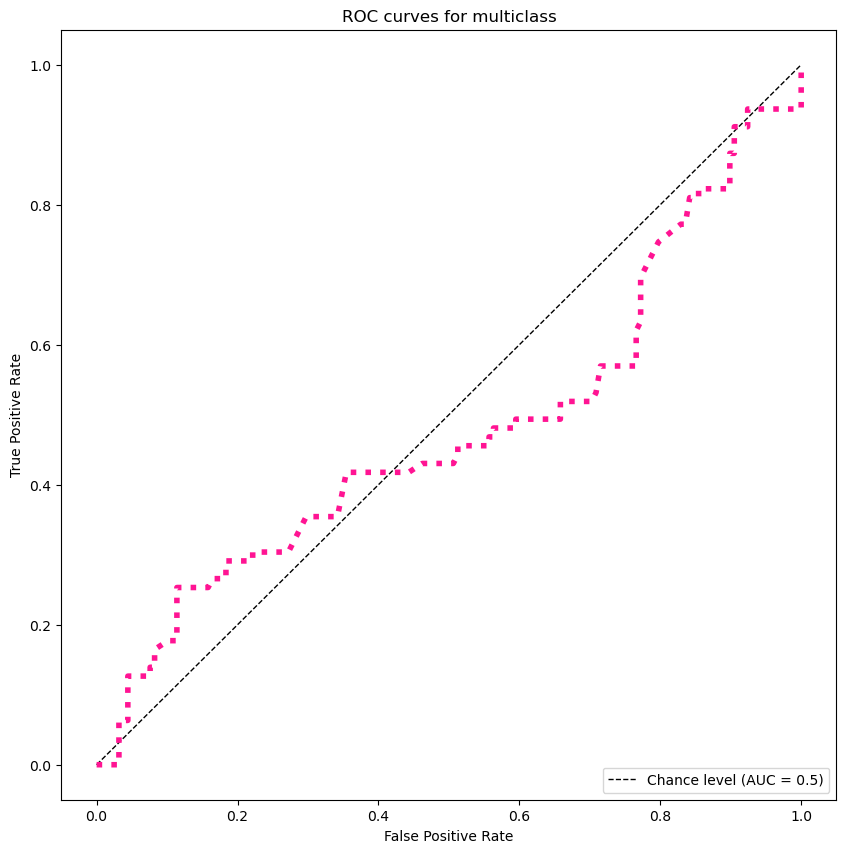

In [ ]:
plot_roc_for_multi_class(model_SVM_3,X_test_3_furth,Y_train_3_furth,Y_test_3_furth,bins_label_3,False,True)

In [ ]:
auc_SVM_3_furth = calculate_micro_auc(model_SVM_3,X_test_3_furth,Y_train_3_furth,Y_test_3_furth)
print(auc_SVM_3_furth)

0.4764460823585964


This model does not look like it is generalising well when we test it on our furthest away cluster

### MCC and F1 with updated parameters ###

In [ ]:
y_pred_SVM_3_furth = model_SVM_3.predict(X_test_3_furth)


In [ ]:
matthews_corrcoef_SVM_3_furth = matthews_corrcoef(Y_test_3_furth,y_pred_SVM_3_furth)
print("MCC:",matthews_corrcoef_SVM_3_furth)

MCC: 0.08776397302724792


In [ ]:
f1_score_SVM_3_micro_furth = f1_score(Y_test_3_furth,y_pred_SVM_3_furth,average="micro")
print("F1 score using micro average is:",f1_score_SVM_3_micro_furth)

F1 score using micro average is: 0.26582278481012656


In [ ]:
f1_score_SVM_3_macro_furth = f1_score(Y_test_3_furth,y_pred_SVM_3_furth,average="macro")
print("F1 score using macro average is:",f1_score_SVM_3_macro_furth)

F1 score using macro average is: 0.24009581721024506


In [ ]:
model_evaluation["model_SVM_3_furthest_cluster"] = {"AUC": auc_SVM_3_furth, "MCC": matthews_corrcoef_SVM_3_furth, "F1": f1_score_SVM_3_micro_furth}

In [ ]:
pd.DataFrame(model_evaluation).T

AUC       MCC        F1
model_SVM_2                   0.822232  0.472637  0.766917
model_SVM_2_GS                0.812716  0.556422  0.805970
model_SVM_2_Optuna            0.831459  0.592428  0.800000
model_SVM_2_Furthest_cluster  0.747756  0.346761  0.721649
model_SVM_3                   0.900890  0.657755  0.773109
model_SVM_3_GS                0.920486  0.709406  0.806723
model_SVM_3_Optuna            0.935315  0.718609  0.806723
model_SVM_3_furthest_cluster  0.476446  0.087764  0.265823

# 10 bin #

In [ ]:
label_to_model_10 = compound_df.bin_10.to_list()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x_10,
    static_test_x_10,
    static_train_y_10,
    static_test_y_10,
) = train_test_split(fingerprint_to_model, label_to_model_10, test_size=0.2, random_state=SEED)
splits_3 = [static_train_x_10, static_test_x_10, static_train_y_10, static_test_y_10]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x_10))
print("Test data size:", len(static_test_x_10))

Training data size: 476
Test data size: 119


In [ ]:
bins_label_10 = ['0','1','2','3','4','5','6','7','8','9']

In [ ]:
model_SVM_10.fit(static_train_x_10,static_train_y_10)
test_prob_10 = model_SVM_10.predict_proba(static_test_x_10)

### Plot the ROC curves using One vs Rest and micro-averaging ###

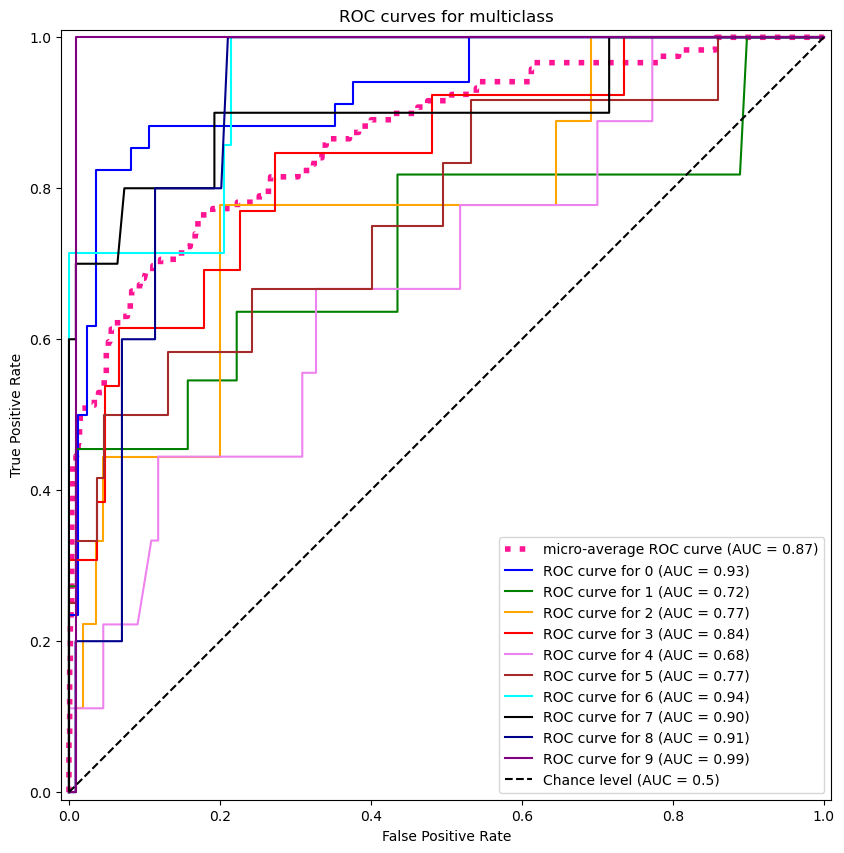

In [ ]:
plot_roc_for_multi_class(model_SVM_10,static_test_x_10,static_train_y_10,static_test_y_10,bins_label_10,True,True)

In [ ]:
auc_SVM_10 = calculate_micro_auc(model_SVM_10,static_test_x_10,static_train_y_10,static_test_y_10)
print(auc_SVM_10)

0.8688024229299562


### MCC for 10 classes ###

In [ ]:
y_pred_SVM_10 = model_SVM_10.predict(static_test_x_10)
matthews_corrcoef_SVM_10 = matthews_corrcoef(static_test_y_10,y_pred_SVM_10)
print("MCC:",matthews_corrcoef_SVM_10)

MCC: 0.4874341289598624


### F1 for multi-class (10 classes here) ###

Have to specify average as this is not a binary class

In [ ]:
f1_score_SVM_10_micro = f1_score(static_test_y_10,y_pred_SVM_10,average="micro")
print("F1 score using micro average is:",f1_score_SVM_10_micro)

F1 score using micro average is: 0.5630252100840336


In [ ]:
f1_score_SVM_10_macro = f1_score(static_test_y_10,y_pred_SVM_10,average="macro")
print("F1 score using macro average is:",f1_score_SVM_10_macro)

F1 score using macro average is: 0.47378256573947414


In [ ]:
model_evaluation["model_SVM_10"] = {"AUC": auc_SVM_10, "MCC": matthews_corrcoef_SVM_10, "F1": f1_score_SVM_10_micro}

### Hyper paramter tuning using random search ###

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the parameter grid
param_grid = {
    'C': uniform(0.0001,10),
    'gamma': uniform(0.00001,10),
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model_SVM_10, param_distributions=param_grid, cv=5, n_iter=100, random_state=SEED)

# Fit the RandomizedSearchCV object to the data
random_search.fit(static_train_x_10, static_train_y_10)

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'C': 0.07076305219717406, 'gamma': 0.23063425041415758, 'kernel': 'poly'}
Best Score: 0.5441228070175439


In [ ]:
model_SVM_10.set_params(**best_params)
model_SVM_10.fit(static_train_x_10, static_train_y_10)

SVC(C=0.07076305219717406, gamma=0.23063425041415758, kernel='poly',
    probability=True)

### Plot the ROC curves using One vs Rest and micro-averaging ###

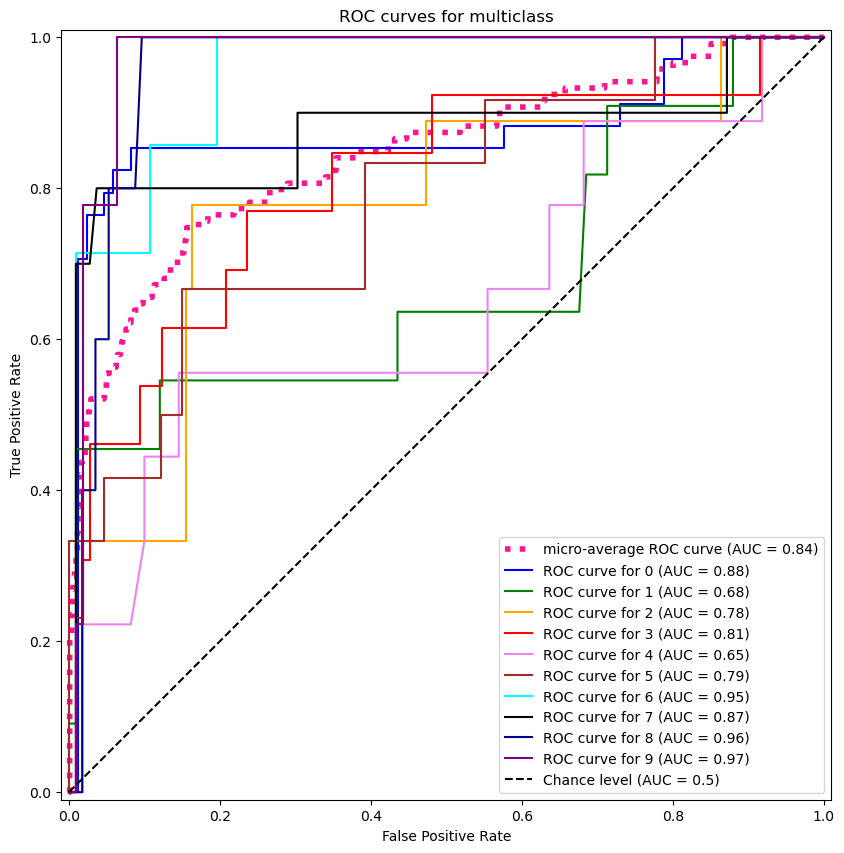

In [ ]:
plot_roc_for_multi_class(model_SVM_10,static_test_x_10,static_train_y_10,static_test_y_10,bins_label_10,True,True)

In [ ]:
auc_SVM_10_RS = calculate_micro_auc(model_SVM_10,static_test_x_10,static_train_y_10,static_test_y_10)
print(auc_SVM_10_RS)

0.8447457414338284


### MCC for 10 classes ###

In [ ]:
y_pred_SVM_10_RS = model_SVM_10.predict(static_test_x_10)
matthews_corrcoef_SVM_10_RS = matthews_corrcoef(static_test_y_10,y_pred_SVM_10_RS)
print("MCC:",matthews_corrcoef_SVM_10_RS)

MCC: 0.5517743819520142


### F1 for multi-class (10 classes here) ###

Have to specify average as this is not a binary class

In [ ]:
f1_score_SVM_10_micro_RS = f1_score(static_test_y_10,y_pred_SVM_10_RS,average="micro")
print("F1 score using micro average is:",f1_score_SVM_10_micro_RS)

F1 score using micro average is: 0.6134453781512605


In [ ]:
f1_score_SVM_10_macro_RS = f1_score(static_test_y_10,y_pred_SVM_10_RS,average="macro")
print("F1 score using macro average is:",f1_score_SVM_10_micro_RS)

F1 score using macro average is: 0.6134453781512605


In [ ]:
model_evaluation["model_SVM_10_RS"] = {"AUC": auc_SVM_10_RS, "MCC": matthews_corrcoef_SVM_10_RS, "F1": f1_score_SVM_10_micro_RS}

In [ ]:
pd.DataFrame(model_evaluation).T

AUC       MCC        F1
model_SVM_2                   0.822232  0.472637  0.766917
model_SVM_2_GS                0.812716  0.556422  0.805970
model_SVM_2_Optuna            0.831459  0.592428  0.800000
model_SVM_2_Furthest_cluster  0.747756  0.346761  0.721649
model_SVM_3                   0.900890  0.657755  0.773109
model_SVM_3_GS                0.920486  0.709406  0.806723
model_SVM_3_Optuna            0.935315  0.718609  0.806723
model_SVM_3_furthest_cluster  0.476446  0.087764  0.265823
model_SVM_10                  0.868802  0.487434  0.563025
model_SVM_10_RS               0.844746  0.551774  0.613445

## Optuna ##

In [ ]:
def objective(trial):
    C = trial.suggest_loguniform("C", 1e-10, 1e2)
    gamma = trial.suggest_loguniform("gamma", 1e-10, 1e1)
    kernel = trial.suggest_categorical("kernel", ['linear', 'rbf','poly','sigmoid'])

    model = svm.SVC(C=C, gamma=gamma, kernel=kernel, probability=True)
    model.fit(static_train_x_10, static_train_y_10)
    y_pred = model.predict(static_test_x_10)
    return f1_score(static_test_y_10, y_pred,average="micro"), calculate_micro_auc(model,static_test_x_10,static_train_y_10,static_test_y_10), matthews_corrcoef(static_test_y_10,y_pred)


In [ ]:
study = optuna.create_study(directions=["maximize","maximize","maximize"],sampler=TPESampler(seed=SEED))
study.optimize(objective, n_trials=100000, timeout=360, n_jobs=8)

[I 2024-07-30 10:58:50,065] A new study created in memory with name: no-name-050c2cb8-bfa6-49e5-a8a8-4e035e2575a7
/tmp/ipykernel_443127/3799099363.py:2: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/tmp/ipykernel_443127/3799099363.py:3: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/tmp/ipykernel_443127/3799099363.py:2: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/tmp/ipykernel_443127/3799099363.py:3: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See

In [ ]:
best_trials = study.best_trials
values = [trial.values for trial in best_trials]
print(values)
sum_of_squares = [sum([x**2 for x in trial]) for trial in values]
max_index = sum_of_squares.index(max(sum_of_squares))
print(values[max_index])
best_param_SVM_10 = best_trials[max_index].params
model_SVM_10.set_params(**best_param_SVM_10)
model_SVM_10.fit(static_train_x_10, static_train_y_10)

[[0.6386554621848739, 0.8519172374832285, 0.5790053370991328], [0.6302521008403361, 0.8579981012012647, 0.5690498610688496], [0.6386554621848739, 0.8508972216337516, 0.5796099748083908], [0.6302521008403361, 0.8831375687529914, 0.5657339677425878], [0.6050420168067226, 0.8860956147164748, 0.5350651518002418], [0.5714285714285714, 0.8861348460953008, 0.5017149049844374], [0.5966386554621849, 0.885389449897606, 0.5389398415790563]]
[0.6302521008403361, 0.8831375687529914, 0.5657339677425878]


SVC(C=4.335053784635609, gamma=0.2044777836905919, probability=True)

### ROC with parameter from Optuna ###

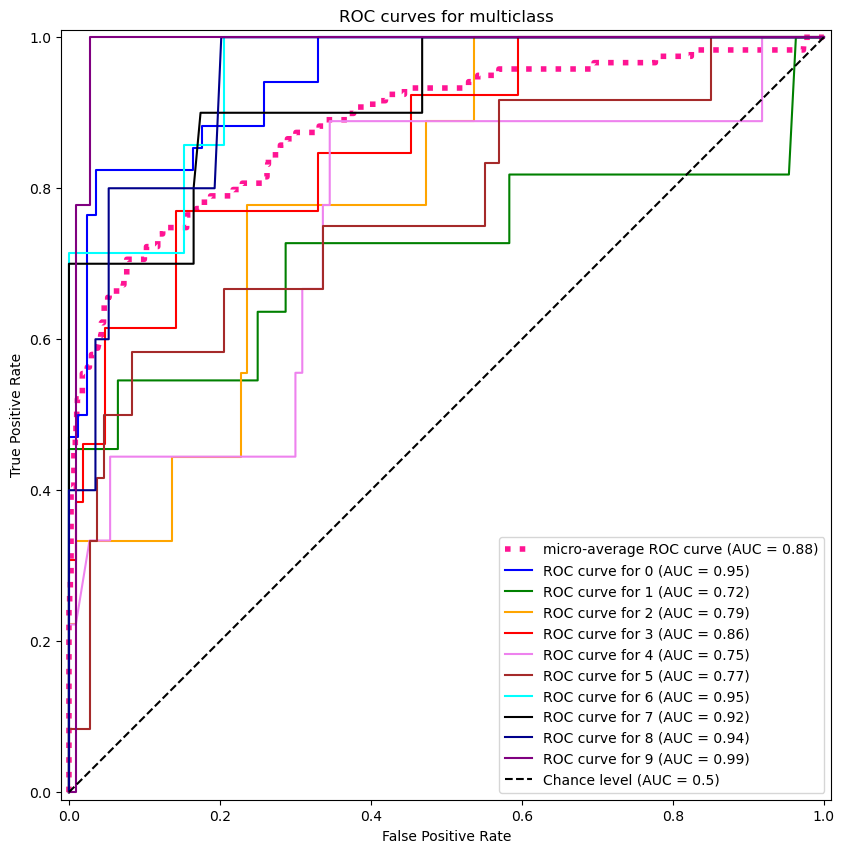

In [ ]:
plot_roc_for_multi_class(model_SVM_10,static_test_x_10,static_train_y_10,static_test_y_10,bins_label_10,True,True)

In [ ]:
auc_SVM_10_Optuna = calculate_micro_auc(model_SVM_10,static_test_x_10,static_train_y_10,static_test_y_10)
print(auc_SVM_10_Optuna)

0.8845106670119027


### MCC and F1 with updated parameters ###

In [ ]:
y_pred_SVM_10_Optuna = model_SVM_10.predict(static_test_x_10)


In [ ]:
matthews_corrcoef_SVM_10_Optuna = matthews_corrcoef(static_test_y_10,y_pred_SVM_10_Optuna)
print("MCC:",matthews_corrcoef_SVM_10_Optuna)

MCC: 0.5657339677425878


In [ ]:
f1_score_SVM_10_micro_Optuna = f1_score(static_test_y_10,y_pred_SVM_10_Optuna,average="micro")
print("F1 score using micro average is:",f1_score_SVM_10_micro_Optuna)

F1 score using micro average is: 0.6302521008403361


In [ ]:
f1_score_SVM_10_macro_Optuna = f1_score(static_test_y_10,y_pred_SVM_10_Optuna,average="macro")
print("F1 score using macro average is:",f1_score_SVM_10_macro_Optuna)

F1 score using macro average is: 0.5845072900955254


Can see a clear improvement in our coefficients here

In [ ]:
model_evaluation["model_SVM_10_Optuna"] = {"AUC": auc_SVM_10_Optuna, "MCC": matthews_corrcoef_SVM_10_Optuna, "F1": f1_score_SVM_10_micro_Optuna}

# Test on furthest cluster #

We define our model using the parameters we got from Optuna

In [ ]:
model_SVM_10.set_params(**best_param_SVM_10)

SVC(C=4.335053784635609, gamma=0.2044777836905919, probability=True)

We will also save this model as it is the best we have so far using our random split so will be helper to be able to call on it again

In [ ]:
joblib_file = "best_model_SVM_10.pkl"
joblib.dump(model_SVM_10, joblib_file)

['best_model_SVM_10.pkl']

Create our furthest cluster splits

In [ ]:
X_test_10_furth, X_train_10_furth, Y_test_10_furth, Y_train_10_furth = furthest_cluster_split(compounds, smiles_column="SMILES", CID_column="CID", pIC50_column="bin_10")

  0%|          | 0/595 [00:00<?, ?it/s][11:04:54] DEPRECATION WARNING: please use MorganGenerator
[11:04:54] DEPRECATION WARNING: please use MorganGenerator
[11:04:54] DEPRECATION WARNING: please use MorganGenerator
[11:04:54] DEPRECATION WARNING: please use MorganGenerator
[11:04:54] DEPRECATION WARNING: please use MorganGenerator
[11:04:54] DEPRECATION WARNING: please use MorganGenerator
[11:04:54] DEPRECATION WARNING: please use MorganGenerator
[11:04:54] DEPRECATION WARNING: please use MorganGenerator
[11:04:54] DEPRECATION WARNING: please use MorganGenerator
[11:04:54] DEPRECATION WARNING: please use MorganGenerator
[11:04:54] DEPRECATION WARNING: please use MorganGenerator
[11:04:54] DEPRECATION WARNING: please use MorganGenerator
[11:04:54] DEPRECATION WARNING: please use MorganGenerator
[11:04:54] DEPRECATION WARNING: please use MorganGenerator
[11:04:54] DEPRECATION WARNING: please use MorganGenerator
[11:04:54] DEPRECATION WARNING: please use MorganGenerator
[11:04:54] DEPREC

In [ ]:
X_train_10_furth = X_train_10_furth.to_list()
Y_train_10_furth = Y_train_10_furth.to_list()
X_test_10_furth = X_test_10_furth.to_list()
Y_test_10_furth = Y_test_10_furth.to_list()

In [ ]:
model_SVM_10.fit(X_train_10_furth, Y_train_10_furth)

SVC(C=4.335053784635609, gamma=0.2044777836905919, probability=True)

### Look at how this model performs when tested on furthest cluster ###

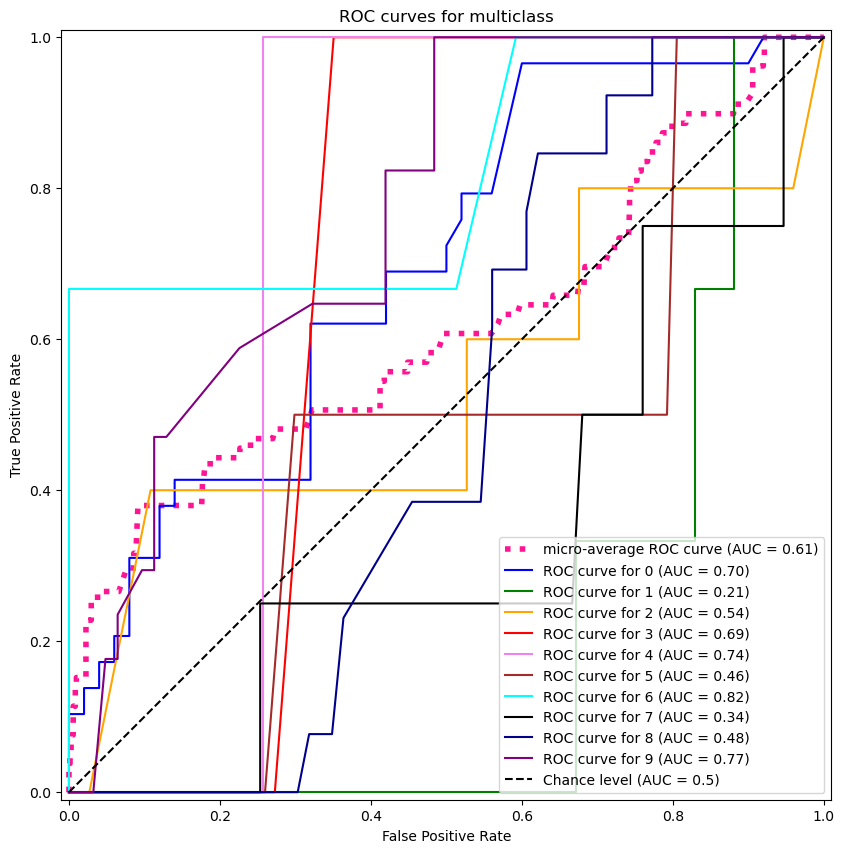

In [ ]:
plot_roc_for_multi_class(model_SVM_10,X_test_10_furth,Y_train_10_furth,Y_test_10_furth,bins_label_10,True,True)

In [ ]:
auc_SVM_10_furth = calculate_micro_auc(model_SVM_10,X_test_10_furth,Y_train_10_furth,Y_test_10_furth)
print(auc_SVM_10_furth)

0.612455268920579


### MCC and F1 with updated parameters ###

In [ ]:
y_pred_SVM_10_furth = model_SVM_10.predict(X_test_10_furth)


In [ ]:
matthews_corrcoef_SVM_10_furth = matthews_corrcoef(Y_test_10_furth,y_pred_SVM_10_furth)
print("MCC:",matthews_corrcoef_SVM_10_furth)

MCC: 0.046371455558912394


In [ ]:
f1_score_SVM_10_micro_furth = f1_score(Y_test_10_furth,y_pred_SVM_10_furth,average="micro")
print("F1 score using micro average is:",f1_score_SVM_10_micro_furth)

F1 score using micro average is: 0.35443037974683544


In [ ]:
f1_score_SVM_10_macro_furth = f1_score(Y_test_10_furth,y_pred_SVM_10_furth,average="macro")
print("F1 score using macro average is:",f1_score_SVM_10_macro_furth)

F1 score using macro average is: 0.05544554455445545


In [ ]:
model_evaluation["model_SVM_10_furthest_cluster"] = {"AUC": auc_SVM_10_furth, "MCC": matthews_corrcoef_SVM_10_furth, "F1": f1_score_SVM_10_micro_furth}

# Table of comparing our different number of classes #

In [ ]:
pd.DataFrame(model_evaluation).T

AUC       MCC        F1
model_SVM_2                    0.822232  0.472637  0.766917
model_SVM_2_GS                 0.812716  0.556422  0.805970
model_SVM_2_Optuna             0.831459  0.592428  0.800000
model_SVM_2_Furthest_cluster   0.747756  0.346761  0.721649
model_SVM_3                    0.900890  0.657755  0.773109
model_SVM_3_GS                 0.920486  0.709406  0.806723
model_SVM_3_Optuna             0.935315  0.718609  0.806723
model_SVM_3_furthest_cluster   0.476446  0.087764  0.265823
model_SVM_10                   0.868802  0.487434  0.563025
model_SVM_10_RS                0.844746  0.551774  0.613445
model_SVM_10_Optuna            0.884511  0.565734  0.630252
model_SVM_10_furthest_cluster  0.612455  0.046371  0.354430

# Visualizing the distribution of our data and training sets to see why performance might suffer #

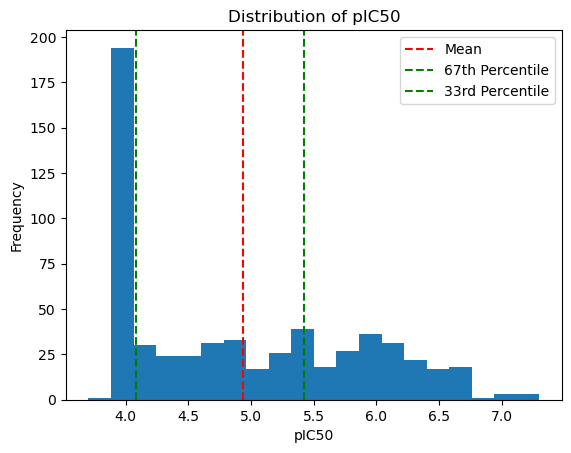

In [15]:
import matplotlib.pyplot as plt

# Set the bin sizes
bin_sizes = 20

# Plot the histogram
plt.hist(compound_df['f_avg_pIC50'], bins=bin_sizes)
# Calculate mean and third quantiles
mean = compound_df['f_avg_pIC50'].mean()
two_third_quantile = compound_df['f_avg_pIC50'].quantile(2/3)
third_quantile = compound_df['f_avg_pIC50'].quantile(1/3)
# Add vertical lines for mean and third quantiles
plt.axvline(mean, color='r', linestyle='--', label='Mean')
plt.axvline(two_third_quantile, color='g', linestyle='--', label='67th Percentile')
plt.axvline(third_quantile, color='g', linestyle='--', label='33rd Percentile')
# Add legend
plt.legend()

# Add labels and title
plt.xlabel('pIC50')
plt.ylabel('Frequency')
plt.title('Distribution of pIC50')
# Save the plot as a PNG file
plt.savefig('Dist_of_pIC50_mean_33_67_percentile_lines.png')
# Show the plot
plt.show()



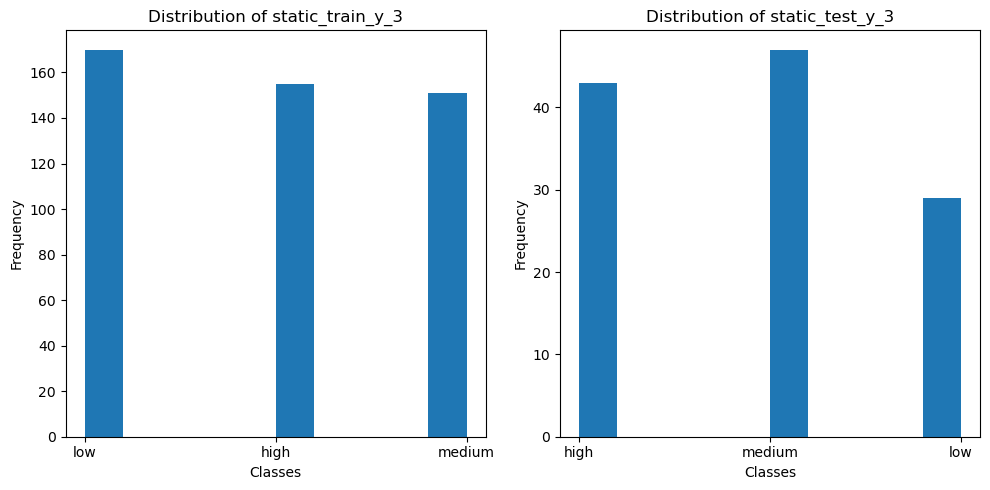

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the distribution of static_train_y_3
axs[0].hist(static_train_y_3)
axs[0].set_title('Distribution of static_train_y_3')
axs[0].set_xlabel('Classes')
axs[0].set_ylabel('Frequency')

# Plot the distribution of static_test_y_3
axs[1].hist(static_test_y_3)
axs[1].set_title('Distribution of static_test_y_3')
axs[1].set_xlabel('Classes')
axs[1].set_ylabel('Frequency')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()